***Syntax natürlicher Sprachen, WS 2022/23***

---
# Übung 13 (Lösung)

In [1]:
from sklearn.metrics import accuracy_score, precision_score,\
    recall_score, f1_score
import nltk

--- 
## Aufgabe 1: Evaluationsmetriken

#### Betrachten Sie folgende Daten. Es handelt sich um ein vereinfachtes Tagging-Schema fürs Chunking, bei dem nur zwischen „Teil einer NP“ (`1`) und „nicht Teil einer NP“ (`0`) unterschieden wird.

In [2]:
ground_truth = [1,0,1,0,0,1,1,1,1,0]
chunker1     = [1,1,1,0,1,0,1,1,1,1]
chunker2     = [1,0,1,0,0,0,0,0,1,0]
chunker3     = [0,0,0,0,0,1,1,1,1,0]

#### Berechnen Sie für jeden der Chunker Accuracy, Precision, Recall und F1-Score zunächst per Hand und überprüfen Sie dann Ihr Ergebnis mit dem folgenden Code.

In [3]:
def accuracy(chunker):
    print(
        "Accuracy:",
        "{:.2f}".format(accuracy_score(ground_truth, chunker))
    )
    print(
        "Precision:",
        "{:.2f}".format(precision_score(ground_truth, chunker))
    )
    print(
        "Recall:",
        "{:.2f}".format(recall_score(ground_truth, chunker))
    )
    print(
        "F1-Score:",
        "{:.2f}".format(f1_score(ground_truth, chunker))
    )

In [4]:
accuracy(chunker1)

Accuracy: 0.60
Precision: 0.62
Recall: 0.83
F1-Score: 0.71


In [5]:
accuracy(chunker2)

Accuracy: 0.70
Precision: 1.00
Recall: 0.50
F1-Score: 0.67


In [6]:
accuracy(chunker3)

Accuracy: 0.80
Precision: 1.00
Recall: 0.67
F1-Score: 0.80


---
## Aufgabe 2: Herunterladen von Ressourcen

#### Das CoNLL 2000 Korpus ist ein POS- und Chunk-getaggtes Korpus (IOB- Format), das in ein Test- und ein Trainingskorpus aufgeteilt ist. Wir werden es zum Training und zur Evaluation von Chunk-Parsern verwenden. Laden Sie es sich dafür zunächst über die Ressource `corpora/conll2000` herunter.

In [7]:
# nltk.download()

#### Wenn Sie es erfolgreich heruntergeladen haben, können Sie folgendermaßen darauf zugreifen:

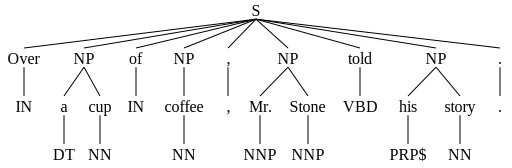

In [8]:
from nltk.corpus import conll2000
conll2000.chunked_sents('train.txt', chunk_types=['NP'])[99]

#### Das `chunk_types`-Argument dient der Auwahl von Chunk-Typen (in diesem Beispiel Nominalphrasen).

--- 
## Aufgabe 3: Chunking mit regulären Ausdrücken

#### Erstellen Sie einen einfachen `RegexpParser`, der für Nominalphrasen charakteristische Tags zu NPs zusammenfasst. Solche charakteristischen Tags sind z.B. Kardinalzahlen (`CD`), Artikel (`DT`), Adjektive (`JJ`, `JJR`, `JJS`) und natürlich Substantive (`NN`, `NNS`, `NNP`, `NNPS`).

#### Weitere interessante Tags wären `PDT` (z.B. *both*, *a lot of*), `POS` (*'s*), `PRP` (Personalpronomen), `PRP$`(Possessivpronomen).

In [9]:
regex = r"""NP:
{<PDT>?<(DT|CD|PRP\$)>?<JJ.?>*<NN.?>+}
{<PRP>}"""

#### Evaluieren Sie Ihren Parser anschließend auf dem CoNLL 2000 Korpus:

In [10]:
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
cp = nltk.RegexpParser(regex)
print(cp.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  86.0%%
    Precision:     79.0%%
    Recall:        73.4%%
    F-Measure:     76.1%%


--- 
## Aufgabe 4: Datenbasiertes Chunking

---
### Aufgabe 4 a:

#### Betrachten Sie den folgenden Code für einen Chunker, der für jedes POS-Tag das wahrscheinlichste Chunk-Tag berechnet (Training) und dieses dann zur Testzeit ausgibt.


In [11]:
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [
            [
                (t,c)
                for w,t,c in nltk.chunk.tree2conlltags(sent)
            ]
            for sent in train_sents
        ]
        self.tagger = nltk.UnigramTagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [
            chunktag for (pos, chunktag) in tagged_pos_tags
        ]
        conlltags = [
            (word, pos, chunktag)
            for ((word, pos), chunktag)
            in zip(sentence, chunktags)
        ]
        return nltk.chunk.conlltags2tree(conlltags)

#### Trainieren und evaluieren Sie den UnigramChunker auf dem CoNLL 2000 Korpus.

In [12]:
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
uc = UnigramChunker(train_sents)
print(uc.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


#### Um uns einen Überblick darüber zu verschaffen, was der Chunker gelernt hat, können wir ihn für jedes mögliche POS-Tag eine Vorhersage treffen lassen:

In [13]:
postags = sorted(set(pos for sent in train_sents for (word,pos) in sent.leaves()))
uc.tagger.tag(postags)

[('#', 'B-NP'),
 ('$', 'B-NP'),
 ("''", 'O'),
 ('(', 'O'),
 (')', 'O'),
 (',', 'O'),
 ('.', 'O'),
 (':', 'O'),
 ('CC', 'O'),
 ('CD', 'I-NP'),
 ('DT', 'B-NP'),
 ('EX', 'B-NP'),
 ('FW', 'I-NP'),
 ('IN', 'O'),
 ('JJ', 'I-NP'),
 ('JJR', 'B-NP'),
 ('JJS', 'I-NP'),
 ('MD', 'O'),
 ('NN', 'I-NP'),
 ('NNP', 'I-NP'),
 ('NNPS', 'I-NP'),
 ('NNS', 'I-NP'),
 ('PDT', 'B-NP'),
 ('POS', 'B-NP'),
 ('PRP', 'B-NP'),
 ('PRP$', 'B-NP'),
 ('RB', 'O'),
 ('RBR', 'O'),
 ('RBS', 'B-NP'),
 ('RP', 'O'),
 ('SYM', 'O'),
 ('TO', 'O'),
 ('UH', 'O'),
 ('VB', 'O'),
 ('VBD', 'O'),
 ('VBG', 'O'),
 ('VBN', 'O'),
 ('VBP', 'O'),
 ('VBZ', 'O'),
 ('WDT', 'B-NP'),
 ('WP', 'B-NP'),
 ('WP$', 'B-NP'),
 ('WRB', 'O'),
 ('``', 'O')]

---
### Aufgabe 4 b:

#### Der `ConsecutiveNPChunker`, dessen Code Sie in der nächsten Zelle sehen, basiert auf einem Klassifikator.

In [14]:
class ConsecutiveNPChunkTagger(nltk.TaggerI):

    def __init__(self, train_sents, npchunk_features):
        self.extract_features = npchunk_features
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.NaiveBayesClassifier.train(train_set)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = self.extract_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI):
    def __init__(self, train_sents, npchunk_features):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents, npchunk_features)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

#### Dies erlaubt uns, die Features, die für die Klassifikation extrahiert werden, genauer zu bestimmen.

#### Ein Feature-Extraktor lässt sich als Funktion z.B. so definieren:

In [15]:
def pos_feature(sentence, i, history):
    word, pos = sentence[i]
    return {"pos": pos}

#### Dieser Feature-Extraktor extrahiert genau ein Feature, nämlich das POS-Tag, das auch der UnigramChunker verwendet hat.

#### Evaluieren Sie den `ConsecutiveNPChunker` mit diesem Feature-Extraktor und vergleichen Sie seine Performanz mit der des `UnigramChunker`s.

In [16]:
chunker = ConsecutiveNPChunker(train_sents, pos_feature)
print(chunker.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


---
### Aufgabe 4 c:

#### Fügen Sie weitere Features für
- das aktuelle Wort,
- das vorhergehende POS-Tag und
- das vorhergehende Chunk-Tag

#### zur Extraktion hinzu und beobachten Sie jeweils die Auswirkungen auf die Performanz in der Evaluation.

In [17]:
def word_feature(sentence, i, history):
    word, pos = sentence[i]
    return {"pos": pos, "word": word}

def previous_pos(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prev_pos = None
    else:
        prev_pos = sentence[i-1][1]

    return {"pos": pos, "word": word, "prev_pos": prev_pos}

def previous_chunk(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prev_pos = None
        prev_chunk = None
    else:
        prev_pos = sentence[i-1][1]
        prev_chunk = history[-1]
    
    return {"pos": pos, "word": word, "prev_pos": prev_pos,
            "prev_chunk": prev_chunk}

In [18]:
chunker = ConsecutiveNPChunker(train_sents, word_feature)
print(chunker.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  92.4%%
    Precision:     74.9%%
    Recall:        85.0%%
    F-Measure:     79.7%%


In [19]:
chunker = ConsecutiveNPChunker(train_sents, previous_pos)
print(chunker.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  94.4%%
    Precision:     84.1%%
    Recall:        89.8%%
    F-Measure:     86.9%%


In [20]:
chunker = ConsecutiveNPChunker(train_sents, previous_chunk)
print(chunker.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  94.5%%
    Precision:     85.0%%
    Recall:        89.6%%
    F-Measure:     87.3%%
